<a href="https://colab.research.google.com/github/OldWizard209/Mask-Detection-AI-using-CNN-s-and-Object-Detection/blob/main/Mask_Detection_AI_Final_Draft_TKS_Project_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, cv2, random, pathlib   # For directories, computer vision, and randomizing data for predictions.
                                  # CV2 is short for copmuter vision, which is used to convert the images into arrays. Because copmuter only understand numbers.
import pandas as pd               # For DataFrames, this is only used to confirm our data's accuracy. It is not necessary
import numpy as np                # For converting python arrays into C/C++ arrays for faster computation. 

import matplotlib.pyplot as plt   # Visualizing our array-ed images.
import matplotlib.image as mpimg  # ^^^^

import tensorflow as tf           # I am using tensorflow for most of the model. The below classes are for layering the NN, and making models. 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split                # Scikit-Learn is only imported here for splitting the data into test-train sets.
from sklearn.metrics import classification_report, confusion_matrix # Confusion Matrix is for finding out the performance of our model.

from google.colab import files



In [ ]:
files.upload()  # Upload the API key from kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oldwizard209","key":"5d44783cf64aecaee2febe7407a7ab52"}'}

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content" # Configure kaggle's directory onto collab

In [ ]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset # Upload the dataset from kaggle

 93% 193M/207M [00:09<00:00, 22.7MB/s]
100% 207M/207M [00:09<00:00, 21.8MB/s]


In [ ]:
!unzip \*.zip # Unzip the zipped code

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/New Masks Dataset"):  # Iterate over every file in our directory and print out the directory names, .etc.
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 0 images in '/content/New Masks Dataset'
There are 2 directories and 0 images in '/content/New Masks Dataset/Test'
There are 0 directories and 50 images in '/content/New Masks Dataset/Test/Mask'
There are 0 directories and 50 images in '/content/New Masks Dataset/Test/Non Mask'
There are 2 directories and 0 images in '/content/New Masks Dataset/Validation'
There are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Mask'
There are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Non Mask'
There are 2 directories and 0 images in '/content/New Masks Dataset/Train'
There are 0 directories and 300 images in '/content/New Masks Dataset/Train/Mask'
There are 0 directories and 300 images in '/content/New Masks Dataset/Train/Non Mask'


In [ ]:
def view_image(target_dir:str, target_class:str):   # I created a function here to view a random image from the dataset. Matplotlib is used for this
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"image shape {img.shape}")
  return img


['114.jpg']
image shape (433, 327, 3)


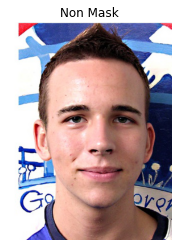

In [ ]:
img = view_image("/content/New Masks Dataset/Train/", "Non Mask") # Here I've run the above function to print a random image.

['1041.jpg']
image shape (500, 500, 3)


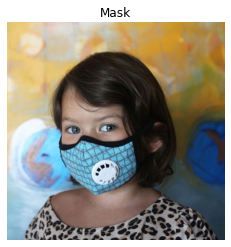

In [ ]:
img = view_image("/content/New Masks Dataset/Train/", "Mask") # Here once again, I've run the above function to print a random image, but this time wearing a mask.

In [ ]:
fie_path = "/content/New Masks Dataset/Train/"    # I only converted the images in the training folder for my entire model, to keep it consice as I didn't weant to work with a massive dataset on my first time doing something like this
data = []         # This array will contain all the iamges converted into one huge array.
labels = []       # This array will contain the labels of the images, 0 for Non Mask, and 1 for Mask, as this is binary classification.

no_mask = os.listdir("/content/New Masks Dataset/Train/Non Mask/") # Referring to the Non Mask directory.

for i in no_mask:                                                       # Iterating over every non mask image, 
  image = cv2.imread("/content/New Masks Dataset/Train/Non Mask/" + i)  # then using cv2 to read, and convert it into an array
  image = cv2.resize(image, (224, 224))                                 # Then resizing the images, as all of them are different sizes, and the ML model wouldn't work if you haven't resized it properly.

  data.append(image)  # Appending the array
  labels.append(0)    # Appedning the labels

In [ ]:
# Doing the same as above, but this time with Mask dataset. Now I know the first rule while writing Python code is that if something is being repeated, the code is not being written properly.
# Right here, I could potentially use a list of non mask, and mask category, iterate over it, and iterate over every iamge after passing it into the common directory, 
# however, I didn't do it as it was too risky for my model, and my tiny brain wouldn't be able to comprehend the data in the lists if I tried to sort it out.
mask = os.listdir("/content/New Masks Dataset/Train/Mask/") 

for i in mask:
  image = cv2.imread("/content/New Masks Dataset/Train/Mask/" + i)
  image = cv2.resize(image, (224, 224))

  data.append(image)
  labels.append(1)

In [ ]:
data = np.array(data) / 255.0 # Now finally, I converted the big array into a numpy array, and diveded by 255. 
                              # Now the reason I divided by 255, is because the RBG color values go up to 255, and every element in the images converted to arrays contains an RGB values.
                              # So logically, dividing it by 255, keeps its color value, but just the number becomes smaller, increasing the speed of training the model
                              # Also I didn't have a choice to do this or not, it is EXTREMELY important to do for the functioning of a ML model
labels = np.array(labels)     # Smae thing with labels. C is just better then Python in speed. skill issue Mr.Python, get better.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)
# Woah, ok this is not hard, just looks confuzzling.
# So I divided my data into train and test, as you can see the data of the iamges and the labels are being divided into 80% train, 20% test, with the "test_size=0.2" parameter.
# Now I explained this in the video, but basically "random_state=42" makes sure that the data ain't randomized everytime it runs, now I could use any number,
# but the ML jargon is dat you should always use 42, because every instructor, teacher, research paper, and tutorial uses 42. So why not follow da tradition? 
# Anyways I ain't no David Malan to breach the tradition

In [ ]:
# Believe it or not, this is all we need for creating a Neural Network, that replicates the functions of the brains using neurons and works through the 
# hidden layers to actually predict the probabilities of outcomes. Now i made that look complicated, but in reality MobileNetV2, as i talked about before is doing all the job.
# So I used transfer learning from the MobileNetV2, to actually train my NN. MobileNetV2, is a CNN, Convolutional NN with a convolutional layer.
# Next, I passed the input shape, the weights which is the databse the model was trained on. Now all of this is exaplined in my oversimplified definition in my video. 
# U are probably here cuz of the video, which is why I meantion it. If not, the video will hopefully be linked on the GitHub
base_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3], weights="imagenet", include_top=False)

# Freezing a few layers so that the weights are not chanegd, Again explained in the video
for layer in base_model.layers:
  layer.trainable = False

# Here, I have used the RELU activation, which passes a 1 to the next layer if the output is greater than 0, else it just passes 0
# The last activation function used is a SIGMOID function, which basically ensures that the final probabilites is either 0 or a 1. This layer will be the last before the output layer.
# Also sigmoid is for binary classifciation. If u are doing multiclass classification, we would use softmax function
# i am so proud of my research ;)
model = Flatten()(base_model.output)
model = Dense(units=256, activation="relu")(model) # Rectified Linear Activation 1 else 0
model = Dense(units=64, activation="relu")(model)
prediction_layer = Dense(units=1, activation="sigmoid")(model) # Will be 0 or 1. SoftMax

model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy']) # Adam for optimization of DL models. loss

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.fit(X_train, y_train, epochs=15, batch_size=32) # Fit da model, and train it

Epoch 1/15
15/15 [==============================] - 15s 797ms/step - loss: 1.1329 - accuracy: 0.8750
Epoch 2/15
15/15 [==============================] - 12s 793ms/step - loss: 0.0658 - accuracy: 0.9896
Epoch 3/15
15/15 [==============================] - 12s 794ms/step - loss: 0.0637 - accuracy: 0.9958
Epoch 4/15
15/15 [==============================] - 12s 807ms/step - loss: 0.0171 - accuracy: 0.9979
Epoch 5/15
15/15 [==============================] - 12s 820ms/step - loss: 0.0040 - accuracy: 0.9979
Epoch 6/15
15/15 [==============================] - 12s 814ms/step - loss: 0.0288 - accuracy: 0.9979
Epoch 7/15
15/15 [==============================] - 12s 821ms/step - loss: 0.0052 - accuracy: 0.9979
Epoch 8/15
15/15 [==============================] - 12s 798ms/step - loss: 8.1943e-07 - accuracy: 1.0000
Epoch 9/15
15/15 [==============================] - 12s 805ms/step - loss: 1.7805e-05 - accuracy: 1.0000
Epoch 10/15
15/15 [==============================] - 12s 814ms/step - loss: 1.3376e

In [ ]:
predictions = model.predict(X_test)   # Lastly, this is for confirmation not neseceray (I cant spell nesecerry).
# Create an array for ma probabilities.
predict = []
# Iterate over each and check if they are either mask or no mask depending on the probabs.
for i in range(len(predictions)):
  if predictions[i][0] > 0.5:
    predict.append(1)

  else:
    predict.append(0)

In [ ]:
pd.DataFrame(confusion_matrix(y_test, predict), columns=["No Mask", "Mask"], index=["No Mask", "Mask"]) # Lastly, also not nesecary,  check using pandas.

,No Mask,Mask
No Mask,59,1
Mask,0,60


In [ ]:
model_name = "/content/mask_new_detection.h5" # Save model, for using the model in jupyter as i cant acces my camera on collab without api as obviously the camera is on my computer.
tf.keras.models.save_model(model, model_name) # Save it.